In [1]:
import numpy as np 
import pickle 
import h5py
from scipy import stats
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import pandas as pd
from pathlib import Path
import re


%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import src.util_analysis as util_analysis

In [2]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_5")
fig_out_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
act_corrs = pd.read_csv('data/figure_5_model_activation_corrs.csv')

In [10]:
def sort_layers(layers):
    # Separate layers into categories
    coch_layers = ['cochleagram', 'norm_coch_rep']
    fc_layers = ['attnfc', 'relufc']
    n_blocks = len([layer for layer in layers if 'hann_pool' in layer])

    block_order = []
    for block_ix in range(n_blocks):
        block_order.append(f'attn{block_ix}')
        block_order.append(f'conv{block_ix}_ln')
        block_order.append(f'conv{block_ix}_relu')
        block_order.append(f'hann_pool_{block_ix}')

    # Combine all categories in the desired order
    return coch_layers + block_order + fc_layers


In [11]:
import re
# Get layer order per model. Will have from [cochleagram, norm_coch_rep, ..., attnfc, relufc]
layer_order_dict = {}

def get_int(val):
    return int(re.search(r'\d+', val).group())

for model in act_corrs['model_name'].unique():
    layers = act_corrs.loc[act_corrs['model_name'] == model, 'layer'].unique()
    sorted_layers = sort_layers(layers)
    for layer in sorted_layers:
        if (model == "Computed-gain model" or 'Backbone' in model) and 'attn' in layer:
            sorted_layers.remove(layer)
        if model == 'Late-only':
            if 'attn' in layer and layer != 'attnfc':
                sorted_layers.remove(layer)
        elif model == 'Early-only':
            if 'attn' in layer:
                layer_int = len(layers) if 'fc' in layer else get_int(layer)
                if layer_int > 0:
                    sorted_layers.remove(layer)
    layer_order_dict[model] = sorted_layers


# Make supplementary figure 10



In [12]:
df_for_agg = act_corrs[act_corrs.model_name.str.contains('main|alt') & ~act_corrs.distractor_condition.str.contains('Natural')].copy()
df_for_agg = df_for_agg.groupby(['model_name', 'group', 'layer', 'Stream']).agg({'Pearson\'s r': ['mean', 'sem']}).reset_index()
df_for_agg.columns = ['model_name', 'group', 'layer', 'Stream', 'r', 'r_sem']
df_for_agg = df_for_agg[df_for_agg.layer.str.contains('cochlea|relu')].reset_index(drop=True)

In [14]:
# control_models = ['Early-only', 'Late-only',  "Feature-gain main random weights"]
# nat sort the other archs 
also_sort = [m for m in all_models if 'rand' not in m and 'main' not in m]
model_order = ['Feature-gain main'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order

model_order = [m for m in model_order if m in all_models]

also_sort = [m for m in all_models if 'rand' in m and 'main' not in m and 'alt' in m]
model_order += ['Feature-gain main random weights'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order

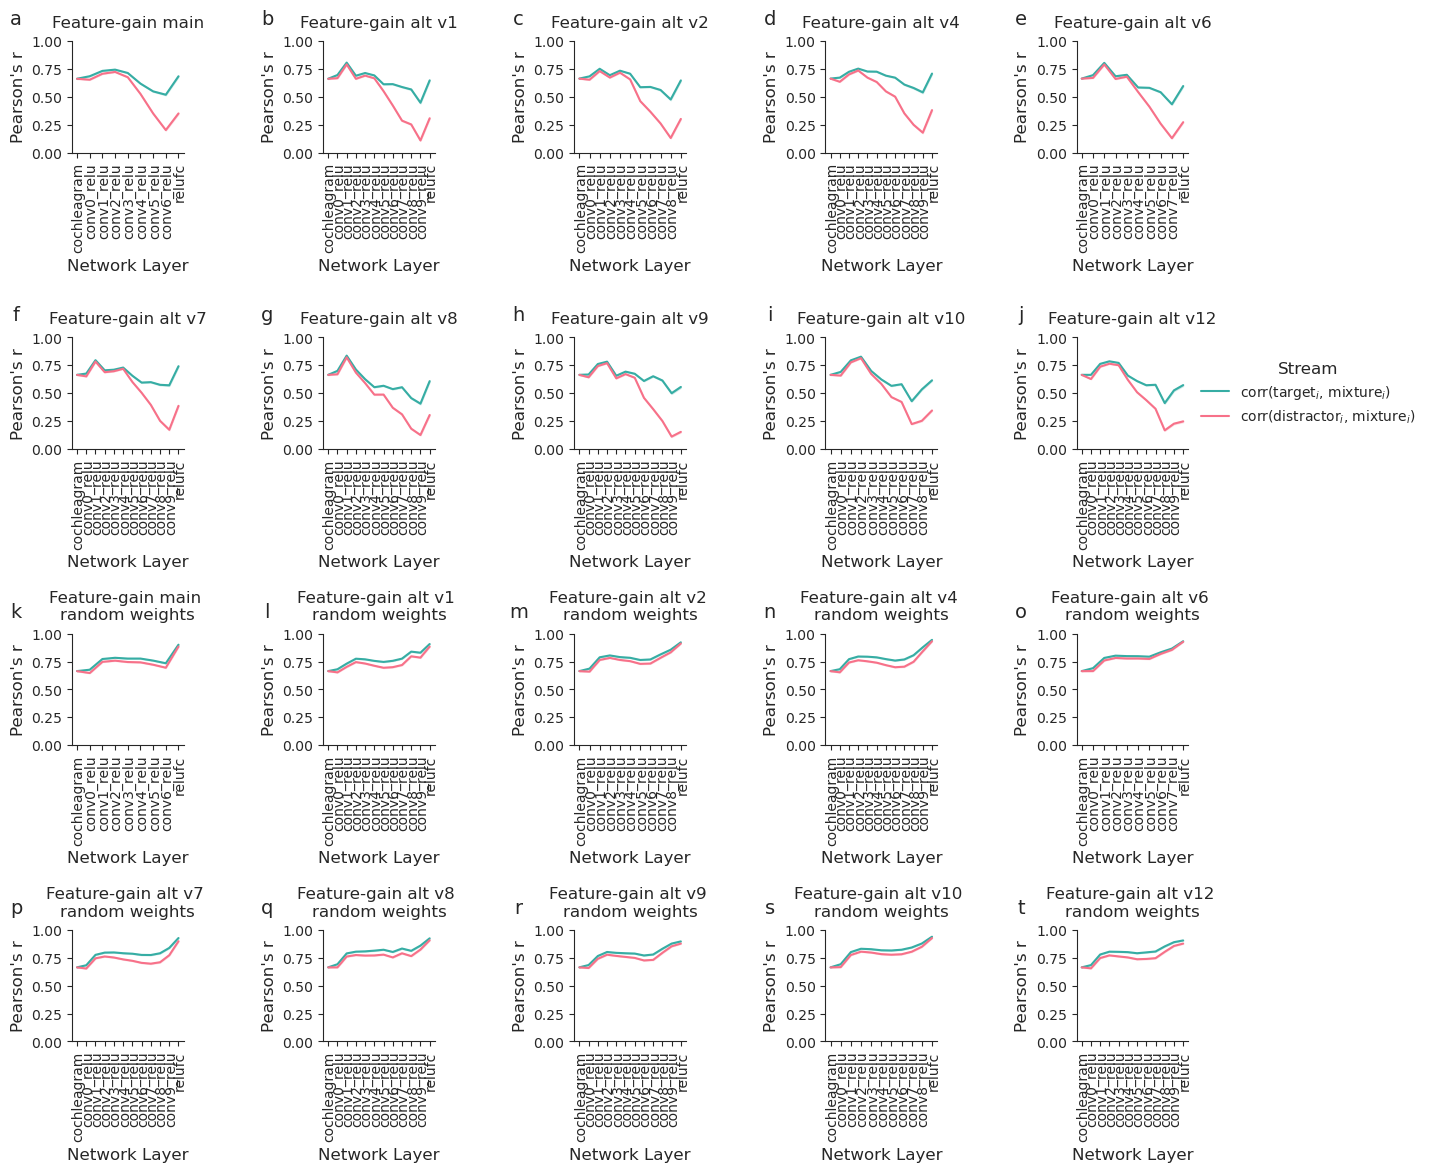

In [ ]:
## Plot summary_results df 
sns.set_style('ticks')

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
col_wrap = 6

all_models = act_corrs['model_name'].unique()
control_models = ['Early-only', 'Late-only',  "Feature-gain main random weights"]
# nat sort the other archs 
also_sort = [m for m in all_models if m not in control_models and 'computed' not in m and 'rand' not in m and 'main' not in m]
model_order = ['Feature-gain main'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order

model_order = [m for m in model_order if m in all_models]

# add random models 
also_sort = [m for m in all_models if m not in model_order and 'computed' not in m and 'rand' in m and 'main' not in m and 'alt' in m]
model_order += ['Feature-gain main random weights'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))# + model_order


n_models = len(model_order)

n_cols = 5
n_rows = 4 
panel_height = 3
fontsize=12

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
axs = axs.flatten()

to_plot = act_corrs[(~act_corrs.distractor_condition.str.contains('Natural'))].copy()

legend_panel = 9
ratio=1
for i, model in enumerate(model_order):
    model_for_panel = to_plot[to_plot['model_name'] == model].set_index('layer')
    layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
    model_for_panel = model_for_panel.loc[layers].reset_index()

    g = sns.lineplot(data=model_for_panel, x='layer', 
                     y="Pearson's r", hue='Stream', ax=axs[i],
                     palette=palette_dict,  hue_order=hue_order,
                     errorbar=('se', 1)
                    )

    axs[i].set_xlabel("Network Layer", size=fontsize)
    axs[i].set_ylabel("Pearson's r", size=fontsize)
    if 'random' in model:
        axs[i].set_title(model.replace('random', '\nrandom'), size=fontsize, y=1.05)
    else:
        axs[i].set_title(model, size=fontsize, y=1.05)
    # set y limit to 0,1
    axs[i].set(ylim=(0,1))

    if i != legend_panel:
        axs[i].legend().remove()

    axs[i].set_xticks(range(len(layers)))
    axs[i].set_xticklabels(labels=layers, rotation=90,  #size=tick_fontsize, 
                           ha='right', va='center_baseline',  rotation_mode='anchor')
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

axs[legend_panel].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stream', frameon=False, title_fontsize=fontsize)

sns.despine()
for ix, ax in enumerate(axs.ravel()):
    if ix >= n_models:
        ax.axis('off')

for ix, ax in enumerate(axs):
    if ix < n_models:
        ax.text(-0.5, 1.2, f'{chr(97+ix)}', transform=ax.transAxes, fontsize=fontsize+2, va='center', ha='center')

ratio = 1 

plt.tight_layout()
# plt.savefig(fig_out_dir / "supplementary_fig_10.pdf", transparent=True, bbox_inches='tight')
